# Summary For Missing Data and Outlier Analysis


In [1]:
import os
import sys  
from pathlib import Path
curr_path = str(Path(os.getcwd()).parent)
sys.path.append(curr_path)

from scripts.transform import *
from scripts.constants import *
from scripts.read import *
from scripts.plotting import *
from scripts.join import *
from scripts.extract import *

import pyspark.sql.functions as F
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, to_date

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

/opt/homebrew/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Create a Spark Session
spark = create_spark()

23/09/15 10:40:56 WARN Utils: Your hostname, Ees-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.12.213.74 instead (on interface en0)
23/09/15 10:40:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/15 10:40:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read in all individual datasets
consumer_fraud = read_landing_consumer_fraud(spark, '.')
merchant_fraud = read_landing_merchant_fraud(spark, '.')
consumer_user_details = read_landing_consumer_user_details(spark, '.')
tbl_consumer = read_landing_tbl_consumer(spark, '.')
tbl_merchants = read_landing_tbl_merchants(spark, '.')

## FUNCTION FOR MISSING DATA


In [4]:
def get_missing_data_parquet(df: DataFrame):
    """
    Get the missing data percentage of the DataFrame
    - Parameters
        - df: DataFrame
    - Returns
        - missing_df: DataFrame of the missing data percentage
    """
    # Calculate first the original count
    original_count = df.count()

    # Calculate missing value percentages for different data types
    missing_df = df.select(*[
        F.when(F.col(c).isNull(), 1).otherwise(0).alias(c)
        for c, t in df.dtypes if t == "string"
    ] + [
        F.when(F.isnan(F.col(c)) | F.col(c).isNull(), 1).otherwise(0).alias(c)
        for c, t in df.dtypes if t not in ("string", "timestamp", "date", "timestamp_ntz")
    ] + [
        F.when(F.col(c).isNull(), 1).otherwise(0).alias(c)
        for c, t in df.dtypes if t in ("timestamp", "date", "timestamp_ntz")
    ])

    # Calculate missing value percentages as a percentage of total rows
    missing_df = missing_df.select([
        (F.sum(F.col(c)) / original_count * 100).alias(c)
        for c in missing_df.columns
    ])

    return missing_df

## MISSING VALUES

### CONSUMER FRAUD

In [5]:
consumer_fraud

user_id,order_datetime,fraud_probability
6228,2021-12-19,97.6298077657765
21419,2021-12-10,99.24738020302328
5606,2021-10-17,84.05825045251777
3101,2021-04-17,91.42192091901347
22239,2021-10-19,94.70342477508035
16556,2022-02-20,89.65663294494827
10278,2021-09-28,83.59136689427714
15790,2021-12-30,71.77065889280253
5233,2021-08-29,85.87123303878818
230,2021-08-28,86.28328808934151


In [6]:
get_missing_data_parquet(consumer_fraud)

order_datetime,user_id,fraud_probability
0.0,0.0,0.0


### MERCHANT FRAUD

In [7]:
merchant_fraud

merchant_abn,order_datetime,fraud_probability
19492220327,2021-11-28,44.403658647495355
31334588839,2021-10-02,42.75530083865367
19492220327,2021-12-22,38.867790051131095
82999039227,2021-12-19,94.1347004808891
90918180829,2021-09-02,43.32551731714902
31334588839,2021-12-26,38.36165958070444
23686790459,2021-12-10,79.4543441508535
14827550074,2021-11-26,46.45775596795885
31334588839,2021-11-26,36.20971272078342
19492220327,2021-12-18,33.819672154331755


In [8]:
get_missing_data_parquet(merchant_fraud)

order_datetime,merchant_abn,fraud_probability
0.0,0.0,0.0


### CONSUMER USER DETAILS

In [9]:
consumer_user_details

user_id,consumer_id
1,1195503
2,179208
3,1194530
4,154128
5,712975
6,407340
7,511685
8,448088
9,650435
10,1058499


In [10]:
get_missing_data_parquet(consumer_user_details)

user_id,consumer_id
0.0,0.0


### CONSUMER_TABLE

In [11]:
tbl_consumer

name,address,state,postcode,gender,consumer_id
Yolanda Williams,413 Haney Gardens...,WA,6935,Female,1195503
Mary Smith,3764 Amber Oval,NSW,2782,Female,179208
Jill Jones MD,40693 Henry Greens,NT,862,Female,1194530
Lindsay Jimenez,00653 Davenport C...,NSW,2780,Female,154128
Rebecca Blanchard,9271 Michael Mano...,WA,6355,Female,712975
Karen Chapman,2706 Stewart Oval...,NSW,2033,Female,407340
Andrea Jones,122 Brandon Cliff,QLD,4606,Female,511685
Stephen Williams,6804 Wright Crest...,WA,6056,Male,448088
Stephanie Reyes,5813 Denise Land ...,NSW,2482,Female,650435
Jillian Gonzales,461 Ryan Common S...,VIC,3220,Female,1058499


In [12]:
get_missing_data_parquet(tbl_consumer)

name,address,state,gender,postcode,consumer_id
0.0,0.0,0.0,0.0,0.0,0.0


### MERCHANT TABLE

In [13]:
tbl_merchants

name,tags,merchant_abn
Felis Limited,"((furniture, home...",10023283211
Arcu Ac Orci Corp...,"([cable, satellit...",10142254217
Nunc Sed Company,"([jewelry, watch,...",10165489824
Ultricies Digniss...,"([wAtch, clock, a...",10187291046
Enim Condimentum PC,([music shops - m...,10192359162
Fusce Company,"[(gift, card, nov...",10206519221
Aliquam Enim Inco...,"[(computers, comP...",10255988167
Ipsum Primis Ltd,"[[watch, clock, a...",10264435225
Pede Ultrices Ind...,([computer progra...,10279061213
Nunc Inc.,"[(furniture, home...",10323485998


In [14]:
get_missing_data_parquet(tbl_merchants)

name,tags,merchant_abn
0.0,0.0,0.0


## OUTLIERS
- Only need to check the outliers for fraud probabilities

In [15]:
def get_fraud_outliers(df:DataFrame) -> tuple:
    """
    Make a tuple containing the outliers in the fraud probabilities
    - Parameters
        - df: DataFrame
    - Returns
        - tuple of outliers
    """
    total_values = df.count()
    df = df.toPandas()
    Q1 = df[FRAUD_PROBABILITY].quantile(0.25)
    Q3 = df[FRAUD_PROBABILITY].quantile(0.75)
    IQR = Q3 - Q1

    # identify outliers
    threshold = 1.5
    outliers_sa2_name_less = list(df[(df[FRAUD_PROBABILITY] < Q1 - threshold * IQR)])
    outliers_sa2_name_more = list(df[(df[FRAUD_PROBABILITY] > Q3 + threshold * IQR)])
    return (round(len(outliers_sa2_name_less)/total_values, 2),
            round(len(outliers_sa2_name_more)/total_values, 2), 
            round((len(outliers_sa2_name_more)+len(outliers_sa2_name_less))/total_values, 2))


In [16]:
get_fraud_outliers(merchant_fraud)

(0.03, 0.03, 0.05)

In [17]:
get_fraud_outliers(consumer_fraud)

(0.0, 0.0, 0.0)

- Only need to check if the merchant_fraud dataset has any outliers

- Before removing outliers

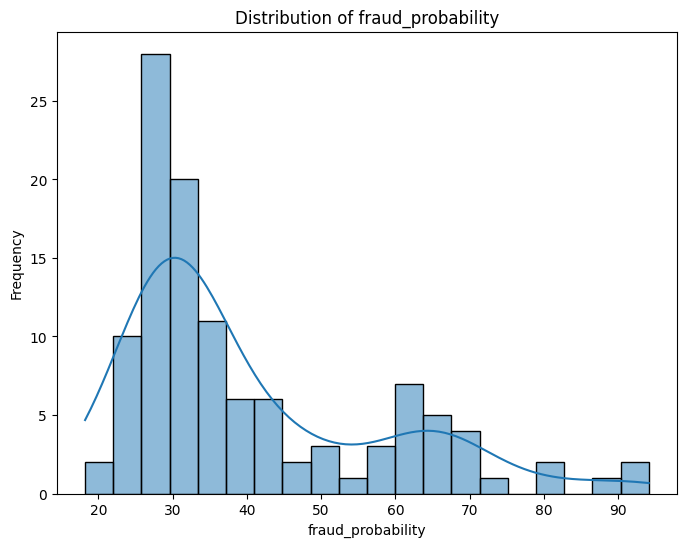

In [18]:
plot_distribution(merchant_fraud.toPandas(), FRAUD_PROBABILITY)

In [19]:
def remove_fraud_outliers(df:DataFrame) -> DataFrame:
    """
    Make a tuple containing the outliers in the fraud probabilities
    - Parameters
        - df: DataFrame
    - Returns
        - tuple of outliers
    """
    total_values = df.count()
    df = df.toPandas()
    Q1 = df[FRAUD_PROBABILITY].quantile(0.25)
    Q3 = df[FRAUD_PROBABILITY].quantile(0.75)
    IQR = Q3 - Q1

    # identify outliers
    threshold = 1.5
    return df[(df[FRAUD_PROBABILITY] >= Q1 - threshold * IQR) | (df[FRAUD_PROBABILITY] <= Q3 + threshold * IQR)]


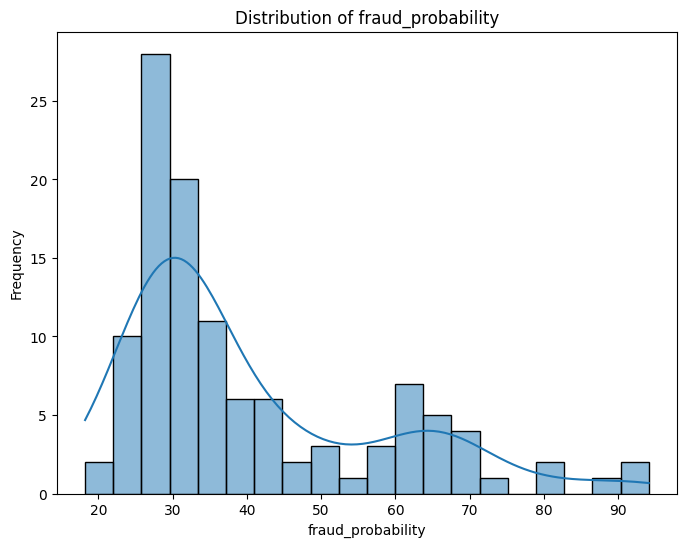

In [20]:
plot_distribution(remove_fraud_outliers(merchant_fraud), FRAUD_PROBABILITY)

- Same distribution, so keep the outliers anyway

## TRANSACTIONS MISSING DATA AND OUTLIERS
- In this case we are only really checking if the dollar values are outliers or not, if there are any extremely high or low values

In [21]:
# Transactions...
transactions_1 = spark.read.parquet(f'.{RAW_DIR}transactions_20210228_20210827_snapshot/*')
transactions_2 = spark.read.parquet(f'.{RAW_DIR}transactions_20210828_20220227_snapshot/*')
transactions_3 = spark.read.parquet(f'.{RAW_DIR}transactions_20220228_20220828_snapshot/*')


## TRANSACTIONS MISSING DATA AND OUTLIERS
- There don't seem to be any missing values in the transactions

In [22]:
missing_transactions_1 = get_missing_data_parquet(transactions_1)
missing_transactions_1

order_id,user_id,merchant_abn,dollar_value
0.0,0.0,0.0,0.0


In [23]:
missing_transactions_2 = get_missing_data_parquet(transactions_2)
missing_transactions_2

order_id,user_id,merchant_abn,dollar_value
0.0,0.0,0.0,0.0


In [24]:
missing_transactions_3= get_missing_data_parquet(transactions_3)
missing_transactions_3

order_id,user_id,merchant_abn,dollar_value
0.0,0.0,0.0,0.0


### TRANSACTIONS DATA OUTLIERS

In [25]:
transactions_1

user_id,merchant_abn,dollar_value,order_id
18478,62191208634,63.255848959735246,949a63c8-29f7-4ab...
2,15549624934,130.3505283105634,6a84c3cf-612a-457...
18479,64403598239,120.15860593212783,b10dcc33-e53f-425...
3,60956456424,136.6785200286976,0f09c5a5-784e-447...
18479,94493496784,72.96316578355305,f6c78c1a-4600-4c5...
3,76819856970,448.529684285612,5ace6a24-cdf0-4aa...
18479,67609108741,86.4040605836911,d0e180f0-cb06-42a...
3,34096466752,301.5793450525113,6fb1ff48-24bb-4f9...
18482,70501974849,68.75486276223054,8505fb33-b69a-412...
4,49891706470,48.89796461900801,ed11e477-b09f-4ae...


In [26]:
# plot_distribution(transactions_1, DOLLAR_VALUE)

In [27]:
# transactions_1.approxQuantile(DOLLAR_VALUE, [0.25, 0.75], 0)

In [28]:
def get_transaction_quantiles(df:DataFrame) -> tuple:
    """
    Get the quantiles of the transaction dollar value
    - Parameters
        - df: DataFrame
    - Returns
        - tuple of quantiles
    """
    Q1, Q3 = df.approxQuantile(DOLLAR_VALUE, [0.25, 0.75], 0)
    return round(Q1, 2), round(Q3, 2)

In [29]:
def get_transaction_outliers(df:DataFrame, Q1:float, Q3:float) -> tuple:
    """
    Get the outliers of the transaction dollar value
    - Parameters
        - df: DataFrame
        - Q1: float
        - Q3: float
    - Returns
        - tuple of outliers
    """
    total_values = df.count()
    IQR = Q3 - Q1
    threshold = 1.5

    # identify outliers
    outliers_less = df.filter(F.col(DOLLAR_VALUE) < Q1 - threshold * IQR).count()
    outliers_more = df.filter(F.col(DOLLAR_VALUE) > Q3 - threshold * IQR).count()
    return (round(outliers_less/total_values, 2),
            round(outliers_more/total_values, 2), 
            round((outliers_more+outliers_less)/total_values, 2))

In [30]:
# Q1, Q3 = get_transaction_quantiles(transactions_3)
# get_transaction_outliers(transactions_3, Q1, Q3)

## JOINING DATASETS for Visualisation

In [31]:
# Join consumer_fraud, consumer_user_details, and tbl_consumer on user_id and consumer_id
consumer_data_join = consumer_fraud.join(consumer_user_details, on = USER_ID, how = INNER_JOIN).join(tbl_consumer, on = CONSUMER_ID, how = INNER_JOIN)
consumer_data_join.show()

23/09/15 10:41:09 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-----------+-------+--------------+------------------+--------------------+--------------------+-----+--------+------+
|consumer_id|user_id|order_datetime| fraud_probability|                name|             address|state|postcode|gender|
+-----------+-------+--------------+------------------+--------------------+--------------------+-----+--------+------+
|        551|   3471|    2022-01-09|30.335537391618317|           Todd Long|883 Patty Mountai...|  NSW|    2021|  Male|
|       1175|   3698|    2021-10-16| 19.65968404776971|Christopher Rodri...|30554 Evans Strea...|  NSW|    2299|  Male|
|       1175|   3698|    2021-11-27| 9.600460566485394|Christopher Rodri...|30554 Evans Strea...|  NSW|    2299|  Male|
|       1549|    667|    2021-09-09|17.802875300207035|   Christopher Walsh|    223 Heather Fort|  QLD|    4705|  Male|
|       1549|    667|    2021-10-04| 9.674041120495586|   Christopher Walsh|    223 Heather Fort|  QLD|    4705|  Male|
|       3105|    895|    2022-02-05| 67.

In [32]:
# Join merchant_fraud and tbl_merchants on merchant_id
merchants_data_join = join_merchant_data(tbl_merchants, merchant_fraud)
merchants_data_join

merchant_abn,name,tags,order_datetime,fraud_probability
10023283211,Felis Limited,"((furniture, home...",null,null
10142254217,Arcu Ac Orci Corp...,"([cable, satellit...",null,null
10165489824,Nunc Sed Company,"([jewelry, watch,...",null,null
10187291046,Ultricies Digniss...,"([wAtch, clock, a...",null,null
10192359162,Enim Condimentum PC,([music shops - m...,null,null
10206519221,Fusce Company,"[(gift, card, nov...",null,null
10255988167,Aliquam Enim Inco...,"[(computers, comP...",null,null
10264435225,Ipsum Primis Ltd,"[[watch, clock, a...",null,null
10279061213,Pede Ultrices Ind...,([computer progra...,null,null
10323485998,Nunc Inc.,"[(furniture, home...",null,null


In [33]:
consumer_data_join.count()

34864

In [34]:
consumer_data_join.printSchema()

root
 |-- consumer_id: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- order_datetime: string (nullable = true)
 |-- fraud_probability: double (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- gender: string (nullable = true)



In [35]:
merchants_data_join.count()

4092

In [36]:
merchants_data_join.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- order_datetime: string (nullable = true)
 |-- fraud_probability: double (nullable = true)



Note: 'fraud_probability' for consumer_data and merchants_data should be a numeric value not a string

## MISSING VALUES ANALYSIS

### CONSUMER DATA

In [37]:
print("Percentage of missing values in Consumer Data:")
get_missing_data_parquet(consumer_data_join)

Percentage of missing values in Consumer Data:


order_datetime,name,address,state,gender,consumer_id,user_id,fraud_probability,postcode
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# Missing values in consumer_data
print("Number of missing values in Consumer Data:")
consumer_data_join.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in consumer_data_join.columns]).show()

Number of missing values in Consumer Data:


+-----------+-------+--------------+-----------------+----+-------+-----+--------+------+
|consumer_id|user_id|order_datetime|fraud_probability|name|address|state|postcode|gender|
+-----------+-------+--------------+-----------------+----+-------+-----+--------+------+
|          0|      0|             0|                0|   0|      0|    0|       0|     0|
+-----------+-------+--------------+-----------------+----+-------+-----+--------+------+



**Consumer Data:**

-> There are missing data in the following columns: 'order_datatime', 'fraud_probability'

### MERCHANTS DATA

In [39]:
print("Percentage of missing values in Merchants Data:")
get_missing_data_parquet(merchants_data_join)

Percentage of missing values in Merchants Data:


name,tags,order_datetime,merchant_abn,fraud_probability
0.4643206256109482,0.4643206256109482,97.21407624633432,0.0,97.21407624633432


In [40]:
# Missing values in merchants_data
print("Number of missing values in Merchants Data:")
merchants_data_join.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in merchants_data_join.columns]).show()

Number of missing values in Merchants Data:
+------------+----+----+--------------+-----------------+
|merchant_abn|name|tags|order_datetime|fraud_probability|
+------------+----+----+--------------+-----------------+
|           0|  19|  19|          3978|             3978|
+------------+----+----+--------------+-----------------+



**Merchants Data:**

-> There are missing data in the following columns: 'name', 'tags'

-> Both columns have missing data in 19 entries.

-> The total number of entries in the current merchants data is 114.

## Exploratory Data Analysis on Joined Datasets

### DESCRIPTIVE STATISTICS FOR CONSUMER AND MERCHANT DATA

In [41]:
consumer_data_join.describe().show()

23/09/15 10:41:17 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+--------------+------------------+------------+--------------------+-----+------------------+-----------+
|summary|       consumer_id|           user_id|order_datetime| fraud_probability|        name|             address|state|          postcode|     gender|
+-------+------------------+------------------+--------------+------------------+------------+--------------------+-----+------------------+-----------+
|  count|             34864|             34864|         34864|             34864|       34864|               34864|34864|             34864|      34864|
|   mean| 751897.9451870124|12057.003929554841|          null|15.120090644154699|        null|                null| null|4050.3173187241855|       null|
| stddev|435809.72949390835| 6963.195640809042|          null| 9.946084849578078|        null|                null| null|1786.5817780499672|       null|
|    min|                30|                 1|    2021-02-28| 8.287143531552802|A

In [42]:
merchants_data_join.describe().show()

+-------+--------------------+--------------------+--------------------+--------------+------------------+
|summary|        merchant_abn|                name|                tags|order_datetime| fraud_probability|
+-------+--------------------+--------------------+--------------------+--------------+------------------+
|  count|                4092|                4073|                4073|           114|               114|
|   mean|5.441496846693157E10|                null|                null|          null| 40.41933469501809|
| stddev|2.609183557184519...|                null|                null|          null|17.187744795432526|
|    min|         10023283211|       A Aliquet Ltd|((Artist supply a...|    2021-03-25| 18.21089142894488|
|    max|         99990536339|Vulputate Velit Inc.|[[watch, clock, a...|    2022-02-27|  94.1347004808891|
+-------+--------------------+--------------------+--------------------+--------------+------------------+



In [43]:
# First,convert fraud probability into a double data type for analysis
consumer_data_analysis = consumer_data_join.withColumn(FRAUD_PROBABILITY, consumer_data_join[FRAUD_PROBABILITY].cast("double"))

# Summary statistics for numeric columns
print("Summary Statistics for Numeric Columns:")
consumer_data_analysis.select(FRAUD_PROBABILITY).describe().show()

Summary Statistics for Numeric Columns:
+-------+------------------+
|summary| fraud_probability|
+-------+------------------+
|  count|             34864|
|   mean|15.120090644154686|
| stddev| 9.946084849578074|
|    min| 8.287143531552802|
|    max| 99.24738020302328|
+-------+------------------+



In [44]:
# First,convert fraud probability into a double data type for analysis
merchant_data_analysis = merchants_data_join.withColumn(FRAUD_PROBABILITY, merchants_data_join[FRAUD_PROBABILITY].cast("double"))

# Summary statistics for numeric columns
print("Summary Statistics for Numeric Columns:")
merchant_data_analysis.select(FRAUD_PROBABILITY).describe().show()

Summary Statistics for Numeric Columns:
+-------+------------------+
|summary| fraud_probability|
+-------+------------------+
|  count|               114|
|   mean| 40.41933469501809|
| stddev|17.187744795432526|
|    min| 18.21089142894488|
|    max|  94.1347004808891|
+-------+------------------+



### DISTRIBUTION - FRAUD PROBABILITY

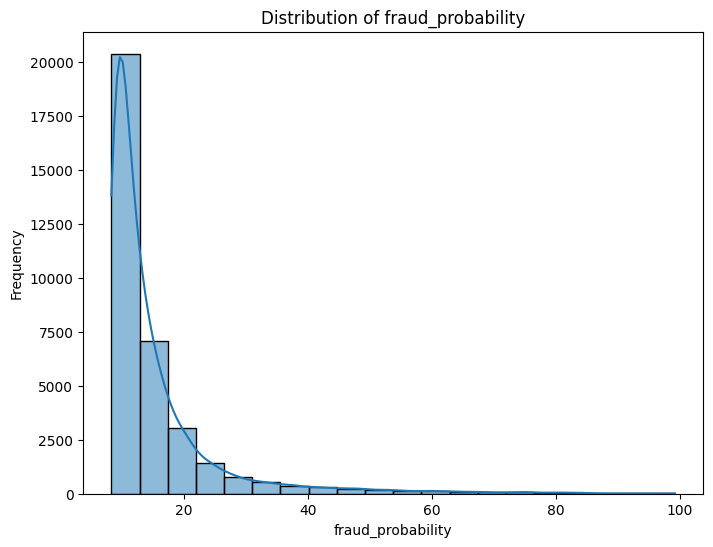

In [45]:
# Data Visualisation for the fraud probabilities in consumer data
plot_distribution(consumer_data_join.toPandas(), FRAUD_PROBABILITY)

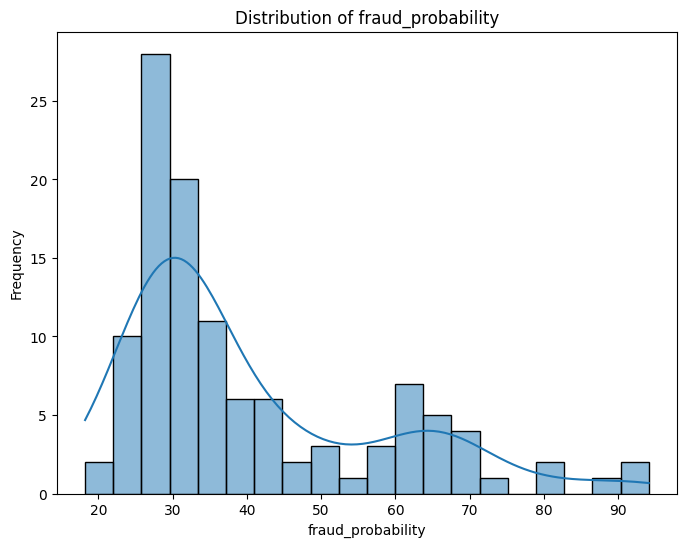

In [46]:
# Data Visualisation for the fraud probabilities in merchants data
plot_distribution(merchants_data_join.toPandas(), FRAUD_PROBABILITY)

### DISTRIBUTION FOR GENDER

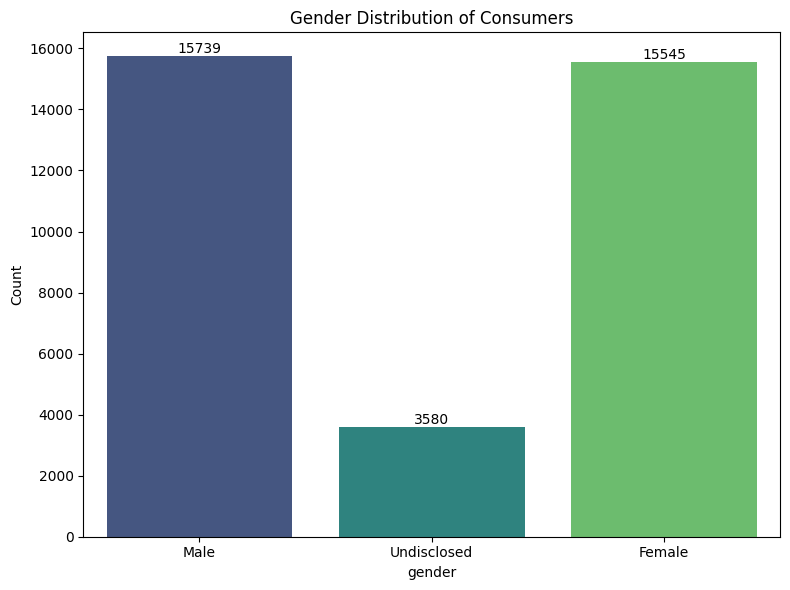

In [47]:
gender_consumer = consumer_data_join.select(F.col(GENDER)).toPandas()
plot_categorical_countplot(gender_consumer, GENDER, "Gender Distribution of Consumers")

### DISTRIBUTION OF CONSUMERS BY STATE

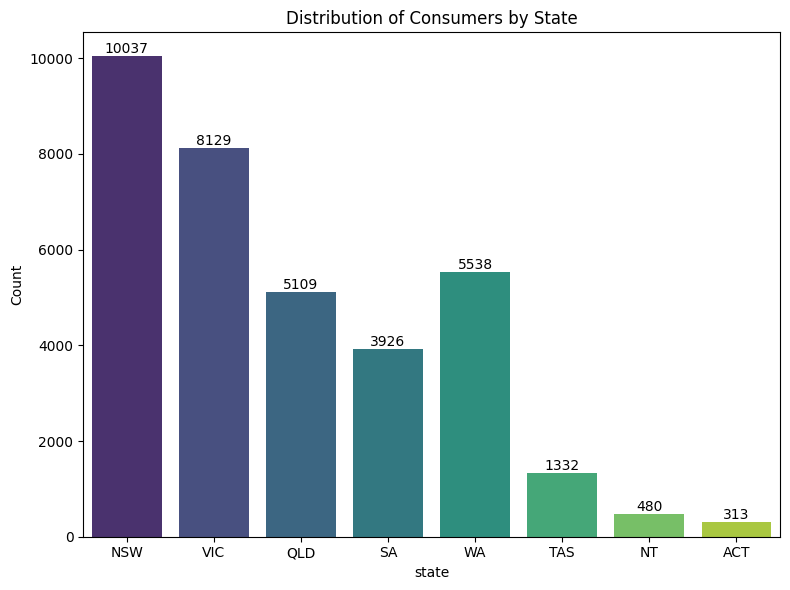

In [48]:
state_consumer = consumer_data_join.select(F.col(STATE)).toPandas()
plot_categorical_countplot(state_consumer, STATE, "Distribution of Consumers by State")

### TIME SERIES ANALYSIS FOR ORDER DATE TIME
- Perform time series aggregation by grouping the data by 'order_datetime; and counting the number of transactions for each day for customers


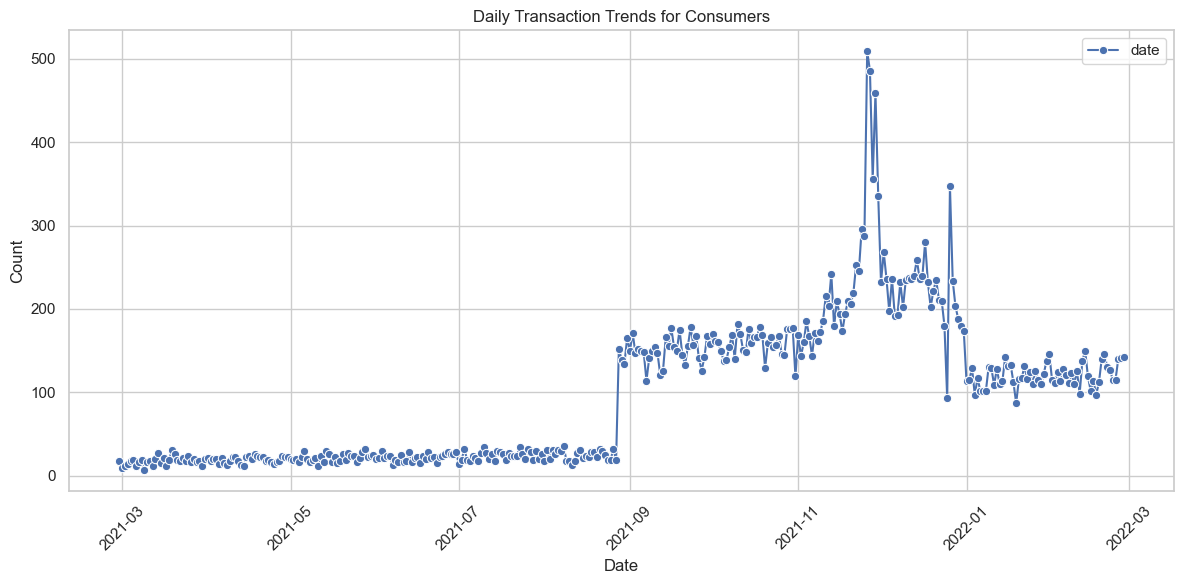

In [49]:
plot_time_series(consumer_data_join, ORDER_DATETIME, 'Daily Transaction Trends for Consumers')